# Modeling: (Monolingual) BERTweet For Sentiment Analysis
*Fine-tuning a BerTweet model for ISP Tweet Sentiment Prediction*

**`Goal:`** Compare the performance of three different models (BERTweet, XLM-roBERTa, and M-BERT) for sentiment analysis. Here, macro-F1 score serves as the key metric of interest

**`Brief Discussion:`** 

Despite the model in my initial [sentiment analysis implementation](https://github.com/KoredeAkande/nigerian_isp_sentiment_analysis/tree/main/notebooks/test-version) struggling with a number of tweets containing pidgin English, I found that tweets in Pidgin English constituted a minority (about 15%) in a randomly extracted sample from our dataset (SEE HERE). Moreover, the tweets featuring Pidgin English used the language very lightly (i.e. a huge proportion of the tweet was still in grammatically correct English). Thus, I hypothesize that a monolingual English model should not have issues predicting sentiment even on Pidgin English. 


In this notebook, I finetune a BERTweet model pretrained on 40k tweets. Specifically, a BERTweet model is selected for finetuning over other models (e.g. BERT model trained on wikipedia) as it gets us closer to our problem domain of tweets, especially English tweets. Thus the model should have learned all the informalities of Twitter and the learn curve should be less steep (as in the case of say, a BERT model).



**`Process:`**
- Load pretrained BERTweet model from transformers package
- Train on an annotated training set of tweets on Nigerian ISPs
- Fine tune on an annotated validation set of tweets on Nigerian ISPs
- Predict unseen tweets in a test set

**`Results:`**
- Across all models, there were struggles in detecting aspects towards the ISP of interest when multiple ISPs were referenced. However, this case seemed to be in the minority.
    
**`Next steps:`**

## 1. Library Importation

In [1]:
#Visualization packages
import pandas as pd
import numpy as np
import seaborn as sns
#sns.set()
import matplotlib.pyplot as plt

#Modeling and evaluation packages
import torch
from transformers import BertForSequenceClassification, BertTokenizer, Trainer, TrainingArguments
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.model_selection import train_test_split

## 2. Loading the data

In [2]:
df = pd.read_csv('../data/processed/sample_encoded_and_cleaned.csv')
df

,ISP_Name,Time,Text,Source,sentiment,label
0,sprectranet,2020-02-04 18:30:35+00:00,my family used my spectranet and they don't wa...,Twitter for Android,Neutral,1
1,sprectranet,2019-06-19 04:59:49,spectranet_ng how can i get the freedom mifi i...,Twitter for iPhone,Neutral,1
2,sprectranet,2020-03-30 07:57:38+00:00,drolufunmilayo iconic_remi spectranet_ng,Twitter for iPhone,Neutral,1
3,sprectranet,2020-12-31 21:07:52+00:00,spectranet_ng your response just proves how ho...,Twitter for Android,Negative,0
4,sprectranet,2020-09-03 23:09:09+00:00,"spectranet is just the worse tbh, i can't even...",Twitter for iPhone,Negative,0
...,...,...,...,...,...,...
372,sprectranet,2019-01-04 14:44:03,spectranet unlimited. value for money,Twitter for iPhone,Positive,2
373,sprectranet,2020-06-17 13:32:28+00:00,from 30th may to date mtn mifi - 10k spectrane...,Twitter for iPhone,Negative,0
374,sprectranet,2020-05-12 16:51:44+00:00,spectranet_ng fritzthejanitor will they help m...,Twitter for iPhone,Neutral,1
375,sprectranet,2019-02-27 18:59:31,thefunkydee spectranet_ng i'm giving spectrane...,Twitter for iPhone,Negative,0


## 3. Split data into training & test set

**Observing the true distribution of the data**

In [3]:
df.label.value_counts(normalize=True)

0    0.572944
1    0.347480
2    0.079576
Name: label, dtype: float64

Seeing as the dataset is highly imbalanced, I perform a **stratified train-test split**:

In [4]:
#Split the data 80:20 and ensure same proportion of classes as original data 
#Note: The below gets the indices of the tweets for the training and test set
X_train, X_test, y_train, y_test = train_test_split(df.index.values, 
                                                    df.label.values, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=df.label.values)

In [5]:
#Note which tweets were split into the training and test sets so we can see the division
df.loc[X_train, 'split_group'] = 'training_set'
df.loc[X_test, 'split_group'] = 'test_set'

In [6]:
df.groupby(['sentiment', 'label', 'split_group'])[['Text']].count().sort_values('label')

Text
sentiment label split_group       
Negative  0     test_set        44
                training_set   172
Neutral   1     test_set        26
                training_set   105
Positive  2     test_set         6
                training_set    24

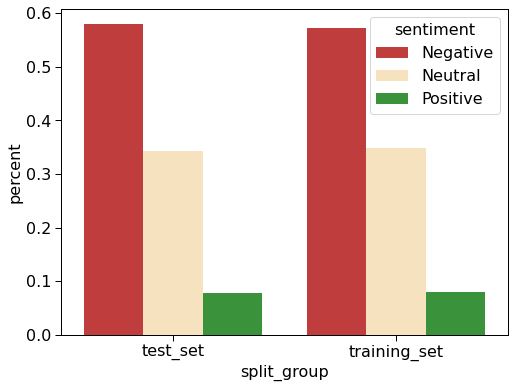

In [7]:
#Plot the proportion of each sentiment class in the training and test sets
#-to confirm the distribution is the same in both sets
with plt.style.context(['notebook','no-latex']):
    sns.barplot(x='split_group', 
                y='percent', 
                hue='sentiment',
                palette = ['tab:red','moccasin','tab:green'],
                data=df.groupby(['split_group'])['sentiment'].value_counts(normalize=True).\
                                                                           rename('percent').\
                                                                           reset_index())
    plt.show()

## 4. Split training set into training set and validation set

In [8]:
#Split the training set 75:25 using stratified sampling 
#Note: The below gets the indices of the tweets for the training and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.25, 
                                                  random_state=1, 
                                                  stratify=y_train)

In [9]:
#Note which tweets were split into the training and validation sets so we can see the division
df.loc[X_train, 'split_group'] = 'training_set'
df.loc[X_val, 'split_group'] = 'validation_set'

In [10]:
df.groupby(['sentiment', 'label', 'split_group'])[['Text']].count().sort_values('label')

Text
sentiment label split_group         
Negative  0     test_set          44
                training_set     129
                validation_set    43
Neutral   1     test_set          26
                training_set      78
                validation_set    27
Positive  2     test_set           6
                training_set      18
                validation_set     6

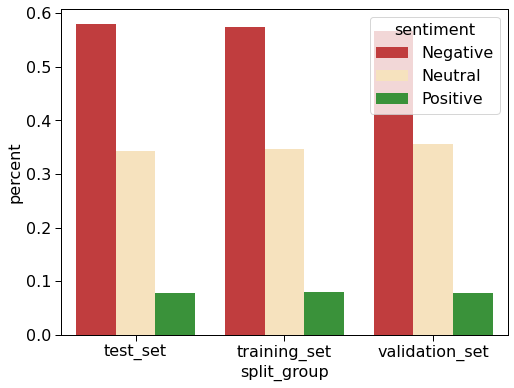

In [11]:
#Plot the proportion of each sentiment class in the training and test sets
#-to confirm the distribution is the same in both sets
with plt.style.context(['notebook','no-latex']):
    sns.barplot(x='split_group', 
                y='percent', 
                hue='sentiment', 
                palette = ['tab:red','moccasin','tab:green'],
                data=df.groupby(['split_group'])['sentiment'].value_counts(normalize=True).\
                                                                         rename('percent').\
                                                                         reset_index())
    plt.show()

In [12]:
df.groupby('split_group')['Text'].count()

split_group
test_set           76
training_set      225
validation_set     76
Name: Text, dtype: int64

## 5. Modeling & Evaluation – BerTweet

In [13]:
#Load BerTweet tokenizer
tokenizer = AutoTokenizer.from_pretrained("finiteautomata/bertweet-base-sentiment-analysis", normalization=True)

class Generate_PyTorch_Dataset(torch.utils.data.Dataset):
    
    """
    Code adapted from NLPiation. (2021). 
    Is it possible to do Sentiment Analysis on unlabeled data using BERT? (Feat. Vader) [Experiment]. 
    https://nlpiation.medium.com/is-it-possible-to-do-sentiment-analysis-on-unlabeled-data-using-bert-feat-vader-experiment-357bba53768c

    """

    def __init__(self, texts, labels, tokenizer):
        self.texts      = texts
        self.labels     = labels
        self.tokenizer  = tokenizer
        self.max_len    = tokenizer.model_max_length
  
    def __len__(self):
        return len(self.texts)
  
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        labels = self.labels[idx]

        encoded_text = self.tokenizer.encode_plus(
            text,
            add_special_tokens    = True,
            truncation            = True,
            return_attention_mask = True,
            return_token_type_ids = False,
            max_length            = self.max_len,
            return_tensors        = 'pt',
            padding               = "max_length"
        )

        return {
            'input_ids': encoded_text['input_ids'][0],
            'attention_mask': encoded_text['attention_mask'][0],
            'labels': torch.tensor(labels, dtype=torch.long)
        }
 

def compute_metrics(eval_pred):
    
    """
    Function to compute accuracy metrics
    
    Input:
        - eval_pred (tuple): Tuple containing the model predictions and targets to be matched 
                             in the form: (predictions,targets)]
                             
    Output:
        - (dict): Dictionary containing different accuracy-related metrics
    
    """
    
    #Get the predicted labels and the true labels
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    #Compute, precision, recall, f1 and accuracy score
    #We use macro so we can better see the effect of the class imbalance i.e. treat all classes as equal
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='macro')
    accuracy = accuracy_score(labels, predictions)
    
    return {
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'accuracy': accuracy}



### a. Encode the training, validation and test sets

In [14]:
#Prepare the Training set
train_set_dataset = Generate_PyTorch_Dataset(
    texts    = df.query("split_group == 'training_set' ").Text.tolist(),
    labels = df.query("split_group == 'training_set' ").label.tolist(),
    tokenizer  = tokenizer
)

#Prepare the validation set
val_set_dataset = Generate_PyTorch_Dataset(
    texts    = df.query("split_group == 'validation_set' ").Text.tolist(),
    labels = df.query("split_group == 'validation_set' ").label.tolist(),
    tokenizer  = tokenizer
)

# Prepare the test set
test_set_dataset = Generate_PyTorch_Dataset(
    texts    = df.query("split_group == 'test_set' ").Text.tolist(),
    labels = df.query("split_group == 'test_set' ").label.tolist(),
    tokenizer  = tokenizer
)

### b. Load Original Pretrained BERTweet model

In [22]:
#Load the original pretrained BERTweet model
bt_model = AutoModelForSequenceClassification.from_pretrained("finiteautomata/bertweet-base-sentiment-analysis")

loading configuration file https://huggingface.co/finiteautomata/bertweet-base-sentiment-analysis/resolve/main/config.json from cache at /Users/koredeakande/.cache/huggingface/transformers/cb09766f7ba60b5f7a1bb640617b24f1499c4a6f3ab160c4a0ac171e3a377c68.008dca06003188334001a96363da79ced4944abc68d94a2f1e0db786dc5aa08b
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "NEG",
    "1": "NEU",
    "2": "POS"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "NEG": 0,
    "NEU": 1,
    "POS": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,


#### • Evaluating the original pre-trained model: How well does it classify tweets?

**Training set (Note: The model was never exposed to these tweets!)**

In [23]:
bt_training_args = TrainingArguments(
    output_dir = "../model_predictions",
    do_predict = True
)

bt_trainer = Trainer(
    model           = bt_model,
    args            = bt_training_args,
    compute_metrics = compute_metrics,
)

bt_train_preds = bt_trainer.predict(train_set_dataset, metric_key_prefix='train')

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running Prediction *****
  Num examples = 225
  Batch size = 8


In [24]:
pd.DataFrame([bt_train_preds[-1]])

,train_loss,train_f1,train_precision,train_recall,train_accuracy,train_runtime,train_samples_per_second,train_steps_per_second
0,0.624887,0.733287,0.736277,0.731001,0.808889,69.5128,3.237,0.417


**Validation set (Note: The model was never exposed to these tweets!)**

In [25]:
bt_val_preds = bt_trainer.predict(val_set_dataset, metric_key_prefix='val')
pd.DataFrame([bt_val_preds[-1]])

***** Running Prediction *****
  Num examples = 76
  Batch size = 8


,val_loss,val_f1,val_precision,val_recall,val_accuracy,val_runtime,val_samples_per_second,val_steps_per_second
0,0.58261,0.73408,0.784722,0.70356,0.802632,20.4717,3.712,0.488


#### • Results discussion

Comparing the pretrained BerTweet to the M-BERT model (ADD LINK), we see that it already starts out predicting our the training and validation sets better than the M-Bert was able to achieve even after training (above metrics around 65%). This indicates that our decision to finetune a pretrained model closer to the problem domain (Twitter tweets) was beneficial despite the model being monolingual (again, this is also helped by the fact that the tweets on Nigerian ISPs were pretty much in English).


The model does great right out of the box! Can we do even better by fine-tuning?

### c. Fine-tuning pretrained BERTweet using Huggingface Trainer

### 5(i) Baseline BerTweet
**`Default Huggingface training configuration`**

In [37]:
#Load the model
bbt_model = AutoModelForSequenceClassification.from_pretrained("finiteautomata/bertweet-base-sentiment-analysis")

#Define the training parameters
bbt_training_args = TrainingArguments(
    output_dir                  = "../models/bertweet/baseline-bertweet",
    num_train_epochs            = 10,
    save_strategy               = "epoch",
    logging_strategy            = "epoch",
    evaluation_strategy         = "epoch"
)

#Define Trainer object
bbt_trainer = Trainer(
    model           = bbt_model,
    args            = bbt_training_args,
    train_dataset   = train_set_dataset,
    eval_dataset    = val_set_dataset,
    compute_metrics = compute_metrics
)

bbt_trainer.train()

***** Running training *****
  Num examples = 225
  Num Epochs = 10
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 290


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,0.757500,0.630531,0.715362,0.769373,0.683463,0.776316
2,0.279200,0.956919,0.739035,0.859585,0.686621,0.789474
3,0.148500,1.061731,0.700635,0.766667,0.666523,0.763158
4,0.076100,0.983990,0.751526,0.857500,0.703560,0.802632
5,0.039000,0.953094,0.821995,0.836490,0.814671,0.828947
6,0.026400,0.902199,0.798151,0.789947,0.811513,0.815789
7,0.006800,0.810084,0.829649,0.819307,0.843956,0.855263
8,0.002700,0.869829,0.818799,0.811243,0.831611,0.842105
9,0.002400,0.901564,0.807721,0.803313,0.819265,0.828947
10,0.002200,0.910789,0.807721,0.803313,0.819265,0.828947


***** Running Evaluation *****
  Num examples = 76
  Batch size = 8
Saving model checkpoint to ../models/bertweet/baseline-bertweet/checkpoint-29
Configuration saved in ../models/bertweet/baseline-bertweet/checkpoint-29/config.json
Model weights saved in ../models/bertweet/baseline-bertweet/checkpoint-29/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 76
  Batch size = 8
Saving model checkpoint to ../models/bertweet/baseline-bertweet/checkpoint-58
Configuration saved in ../models/bertweet/baseline-bertweet/checkpoint-58/config.json
Model weights saved in ../models/bertweet/baseline-bertweet/checkpoint-58/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 76
  Batch size = 8
Saving model checkpoint to ../models/bertweet/baseline-bertweet/checkpoint-87
Configuration saved in ../models/bertweet/baseline-bertweet/checkpoint-87/config.json
Model weights saved in ../models/bertweet/baseline-bertweet/checkpoint-87/pytorch_model.bin
***** Running Evaluation ***

TrainOutput(global_step=290, training_loss=0.1340926980150157, metrics={'train_runtime': 2896.1579, 'train_samples_per_second': 0.777, 'train_steps_per_second': 0.1, 'total_flos': 233111131200000.0, 'train_loss': 0.1340926980150157, 'epoch': 10.0})

#### • Plot train and validation metrics

In [38]:
#Get the baseline bertweet's training logs
bbt_history = pd.DataFrame(bbt_trainer.state.log_history)
bbt_history.to_csv("../models/logs/baseline_bertweet_logs.csv",index=False)
bbt_history = bbt_history.fillna(method='bfill', limit=1).drop_duplicates(subset=['epoch','eval_loss'])

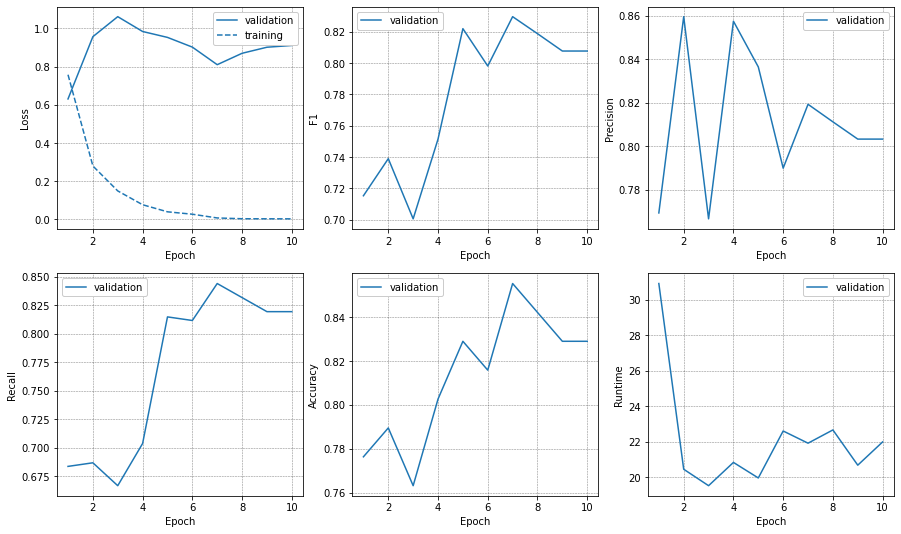

In [47]:
plt.figure(figsize=(15,9))
plt.tight_layout()

metrics = ['eval_loss','eval_f1','eval_precision','eval_recall','eval_accuracy','eval_runtime']

for idx, metric in enumerate(metrics):
    with plt.style.context(['grid']):
        ax = plt.subplot(2,3,idx+1).plot(bbt_history['epoch'],
                                    bbt_history[metric],
                                    label='validation')

        #Also plot training loss when plotting validation loss
        if metric == 'eval_loss':
            ax = plt.subplot(2,3,idx+1).plot(bbt_history['epoch'],
                                             bbt_history['loss'],
                                             color = ax[0].get_color(),
                                             linestyle= "--",
                                             label='training')



        plt.xlabel('Epoch')
        plt.ylabel(metric.replace('eval_','').capitalize())
        plt.legend()

#### • Validation Results Discussion

The best model, corresponding to that from epoch 7 (**checkpoint-203**) had the following validation set results:

- **Validation Loss:** 0.810084
- **F1:** 0.829649
- **Precision:** 0.819307
- **Recall:** 0.843956
- **Accuracy:** 0.855263

The validation loss not really dropping while the training loss does might indicate that the model is overfitting the data. We contrast both the training and validation performanc below and also plot a confusion matrix and classification report to get more context into the model's performance:

#### • [TRAIN] Evaluating training set performance – Baseline BERTweet

In [26]:
#Load the best baseline bertweet model
bbt_model = AutoModelForSequenceClassification.from_pretrained("../models/bertweet/baseline-bertweet/checkpoint-203")

bbt_training_args = TrainingArguments(
    output_dir = "../model_predictions",
    do_predict = True
)

bbt_trainer = Trainer(
    model           = bbt_model,
    args            = bbt_training_args,
    compute_metrics = compute_metrics,
)


bbt_train = bbt_trainer.predict(train_set_dataset, metric_key_prefix= 'train')

loading configuration file ../models/bertweet/baseline-bertweet/checkpoint-203/config.json
Model config RobertaConfig {
  "_name_or_path": "finiteautomata/bertweet-base-sentiment-analysis",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "NEG",
    "1": "NEU",
    "2": "POS"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "NEG": 0,
    "NEU": 1,
    "POS": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.8.0",
  "type_vocab_size": 1,
  "use_ca

In [27]:
pd.DataFrame([bbt_train[-1]])

,train_loss,train_f1,train_precision,train_recall,train_accuracy,train_runtime,train_samples_per_second,train_steps_per_second
0,0.001986,1.0,1.0,1.0,1.0,59.6723,3.771,0.486


Perfect training set prediction

#### • [VALIDATION] Evaluating validation set performance – baseline BERTweet

In [28]:
bbt_validation = bbt_trainer.predict(val_set_dataset, metric_key_prefix= 'val')

***** Running Prediction *****
  Num examples = 76
  Batch size = 8


In [29]:
pd.DataFrame([bbt_validation[-1]])

,val_loss,val_f1,val_precision,val_recall,val_accuracy,val_runtime,val_samples_per_second,val_steps_per_second
0,0.810084,0.829649,0.819307,0.843956,0.855263,20.3342,3.738,0.492


Clearly overfits the data. We see significantly better performance on the training set than the validation set

In [30]:
y_true_val = df.query("split_group == 'validation_set' ").label.tolist()
bbt_val_preds = np.argmax(bbt_validation[0], axis=1).flatten()

print(classification_report(y_true_val, bbt_val_preds))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87        43
           1       0.88      0.81      0.85        27
           2       0.71      0.83      0.77         6

    accuracy                           0.86        76
   macro avg       0.82      0.84      0.83        76
weighted avg       0.86      0.86      0.86        76



Although performance still looks really good. Unsurprisingly, it does poorer with the positive class

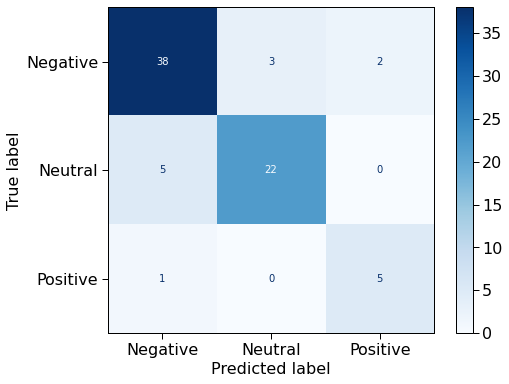

In [31]:
#Generate the confusion matrix
bbt_cm = confusion_matrix(y_true_val, bbt_val_preds)
bbt_disp = ConfusionMatrixDisplay(confusion_matrix=bbt_cm, display_labels = ['Negative', 'Neutral', 'Positive'])

#Plot the confusion matrix
with plt.style.context(['notebook','no-latex']):
    bbt_disp.plot(cmap='Blues',ax=None)
    plt.grid(False)
    plt.show()

#### • View misclassified tweets

In [32]:
valid_df = df.query("split_group == 'validation_set' ")
valid_df['model_preds'] = bbt_val_preds 
misclassified = valid_df[valid_df.label != valid_df.model_preds][['Text','sentiment','model_preds']]
misclassified.model_preds = misclassified.model_preds.map({0:'Negative', 1: 'Neutral', 2: 'Positive'})

with pd.option_context('display.max_colwidth', None):
  display(misclassified)

/Users/koredeakande/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Text,sentiment,model_preds
61,oluwadamilolaog femi_martinsog you are cheating on your darling spectranet again.,Neutral,Negative
78,spectranet expecting me to subscribe without sending double data offer. jokers i want double data plus rollover so till then we wait.,Neutral,Negative
94,"the_cocoreidh spectranet. for optimized speed tests, i get like 200ms ping",Neutral,Negative
108,chenaonuorah please don't buy spectranet ... i beg you in the name of god!,Negative,Positive
113,"iyawothickabody one time spectranet called, i refused to pick because i didn't have money to subscribe so i just ignored it like 4 times. the fifth time, true caller showed union bank, i picked thinking i have passed interview o only to hear 'your spectranet...😂😂😂 they got me😂",Neutral,Negative
155,trying to enjoy my movie but tizeti out here like,Negative,Positive
222,specy spectranet_ng warris all dis na! la ta aro!,Negative,Neutral
261,na gprs una dey run me no lie spectranet_ng,Negative,Neutral
348,is there any internet service provider in nigeria that offers unlimited data for a month with no cap ? asides tizeti please,Negative,Neutral
360,funmiistic tizeti internet service provider.,Neutral,Negative


#### Insights
- Some of the misclassified sentenes could indeed (objectively) be interpreted as the ISP predicts. But since they do not speak specifically to the ISP's performance or service but more so the actions or attitudes of the user, I classify them otherwise e.g. I'm not going to subscribe because I'm waiting for double data (as in sentence 78). Not subscribing indeed has a negative connotation but the user follows up by stating it is because they are waiting to take advantage of a promo and not necessarily because the ISP's performance is bad.

- Seems to struggle to detect the negative sentiments towards the named entity e.g. Spectranet (sentence 108).

- Might be struggling with the pidgin English in the tweets (see sentences 222 and 261). Although sentence 222 also contains Yoruba language

- Possible that since a high proportion of the tweets containing the ISPs names are negative, it automatically relates tweets with no other strongly suggestive words except the ISPs names to 'Negative' e.g. sentence 360 and 372 

#### • Conclusion

##### Pros
- Does a great job predicting all the classes

##### Cons
- Has minor challenges differentiating some positive and negative tweets 
- Lower predictive performance on positive samples. We note however that there were very few positive samples in the validation set and it was able to recall 83% and predict 71% correctly.


#### DID FINETUNING ACTUALLY IMPROVE THE MODEL?

##### Could we do even better? Especially with the positive samples?
- We note that the default batch size of 8 was used. Hence it is very possible that the model trained on numerous batches which didn't have a positive sample. We could try increasing the batch size to increase the chance of the model training on and learning positive samples
- We could also weight positive samples higher so that the model pays more attention to them
- Similar to the first in trying to increase the chances of training on positive samples, we could try oversampling (i.e. resampling) positive tweets.

---

### 5(ii) Modified BerTweet (v1)
**`Loss function reweighting` | `Increased batch size`**

In [ ]:
class CustomTrainer(Trainer):
    
    """
    Class weighted trainer to account for imbalance
    """
    
    def __init__(self, no_of_classes, samples_per_cls, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = self.get_ens_weights(no_of_classes, samples_per_cls)
        
    def get_ens_weights(self, no_of_classes,samples_per_cls,beta=0.99):
    
        """
        Compute class weights using effective number of samples strategy
        """

        effective_num = 1.0 - np.power(beta, samples_per_cls)
        weights = (1.0 - beta) / np.array(effective_num)
        weights = weights / np.sum(weights) * no_of_classes
        weights = torch.tensor(weights.astype(np.float32))
        
        return weights
    
    def compute_loss(self, model, inputs, return_outputs=False):
        
        labels = inputs.get("labels")
        #Forward pass
        outputs = model(**inputs)
        logits = outputs.get('logits')
        #Compute custom loss
        loss_fct = torch.nn.CrossEntropyLoss(weight= self.class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

#Define the training parameters
lrbt_training_args = TrainingArguments(
    output_dir                  = "../models/bertweet/loss-reweighted",
    num_train_epochs            = 20,
    per_device_train_batch_size = 32, #Increase training batch size to ensure that each batch has a decent chance of containing a few positive samples.
    save_steps                  = 20,
    seed                        = 123,
    logging_strategy            = "epoch",
    evaluation_strategy         = "epoch"
)
    
  
#Define Trainer object
lrbt_trainer = CustomTrainer(
    no_of_classes   = len(df.label.unique()),
    samples_per_cls = df.label.value_counts(sort=False).to_list(),
    model           = bt_model,
    args            = lrbt_training_args,
    train_dataset   = train_set_dataset,
    eval_dataset    = val_set_dataset,
    compute_metrics = compute_metrics
)

#Start pre-training!
lrbt_trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 225
  Num Epochs = 20
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 160


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,0.000400,2.260786,0.723356,0.859596,0.669681,0.776316
2,0.023500,2.052974,0.760443,0.869331,0.711312,0.815789
3,0.000100,1.843790,0.784629,0.882232,0.745191,0.842105
4,0.003200,2.182108,0.729020,0.860949,0.674275,0.776316
5,0.006300,1.922617,0.739035,0.859585,0.686621,0.789474
6,0.000100,1.797545,0.815710,0.872917,0.785243,0.828947
7,0.038100,1.449459,0.830435,0.902100,0.786965,0.855263
8,0.022900,1.432764,0.811280,0.836522,0.791559,0.855263
9,0.000100,1.535962,0.817028,0.875645,0.789836,0.828947
10,0.000300,1.357584,0.833726,0.893827,0.796153,0.855263


***** Running Evaluation *****
  Num examples = 76
  Batch size = 8
***** Running Evaluation *****
  Num examples = 76
  Batch size = 8
Saving model checkpoint to ../models/bertweet/loss-reweighted/checkpoint-20
Configuration saved in ../models/bertweet/loss-reweighted/checkpoint-20/config.json
Model weights saved in ../models/bertweet/loss-reweighted/checkpoint-20/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 76
  Batch size = 8
***** Running Evaluation *****
  Num examples = 76
  Batch size = 8
Saving model checkpoint to ../models/bertweet/loss-reweighted/checkpoint-40
Configuration saved in ../models/bertweet/loss-reweighted/checkpoint-40/config.json
Model weights saved in ../models/bertweet/loss-reweighted/checkpoint-40/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 76
  Batch size = 8
***** Running Evaluation *****
  Num examples = 76
  Batch size = 8
***** Running Evaluation *****
  Num examples = 76
  Batch size = 8
Saving model checkpoint 

In [19]:
#Continue training
lrbt_trainer.train("../models/bertweet/loss-reweighted/checkpoint-80")

Loading model from ../models/bertweet/loss-reweighted/checkpoint-80).
***** Running training *****
  Num examples = 225
  Num Epochs = 20
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 160
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 10
  Continuing training from global step 80
  Will skip the first 10 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
11,0.000100,1.564183,0.823188,0.895297,0.779213,0.842105
12,0.000100,1.683910,0.823188,0.895297,0.779213,0.842105
13,0.000100,1.725717,0.823188,0.895297,0.779213,0.842105
14,0.000100,1.748035,0.811908,0.887879,0.766868,0.828947
15,0.000100,1.760115,0.811908,0.887879,0.766868,0.828947
16,0.000100,1.767024,0.811908,0.887879,0.766868,0.828947
17,0.000100,1.771428,0.811908,0.887879,0.766868,0.828947
18,0.000100,1.774259,0.811908,0.887879,0.766868,0.828947
19,0.000000,1.775917,0.811908,0.887879,0.766868,0.828947
20,0.000100,1.776603,0.811908,0.887879,0.766868,0.828947


***** Running Evaluation *****
  Num examples = 76
  Batch size = 8
***** Running Evaluation *****
  Num examples = 76
  Batch size = 8
Saving model checkpoint to ../models/bertweet/loss-reweighted/checkpoint-100
Configuration saved in ../models/bertweet/loss-reweighted/checkpoint-100/config.json
Model weights saved in ../models/bertweet/loss-reweighted/checkpoint-100/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 76
  Batch size = 8
***** Running Evaluation *****
  Num examples = 76
  Batch size = 8
Saving model checkpoint to ../models/bertweet/loss-reweighted/checkpoint-120
Configuration saved in ../models/bertweet/loss-reweighted/checkpoint-120/config.json
Model weights saved in ../models/bertweet/loss-reweighted/checkpoint-120/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 76
  Batch size = 8
***** Running Evaluation *****
  Num examples = 76
  Batch size = 8
***** Running Evaluation *****
  Num examples = 76
  Batch size = 8
Saving model check

TrainOutput(global_step=160, training_loss=2.9874328174628317e-05, metrics={'train_runtime': 2877.6907, 'train_samples_per_second': 1.564, 'train_steps_per_second': 0.056, 'total_flos': 466222262400000.0, 'train_loss': 2.9874328174628317e-05, 'epoch': 20.0})

#### • Plot train and validation metrics

In [33]:
#Get the baseline bertweet's training logs
#lrbt_history = pd.DataFrame(lrbt_trainer.state.log_history)
#lrbt_history.to_csv("../models/logs/loss_reweighted_bertweet_logs.csv",index=False)
lrbt_history = pd.read_csv("../models/logs/loss_reweighted_bertweet_logs.csv")
lrbt_history = lrbt_history.fillna(method='bfill', limit=1).drop_duplicates(subset=['epoch','eval_loss'])

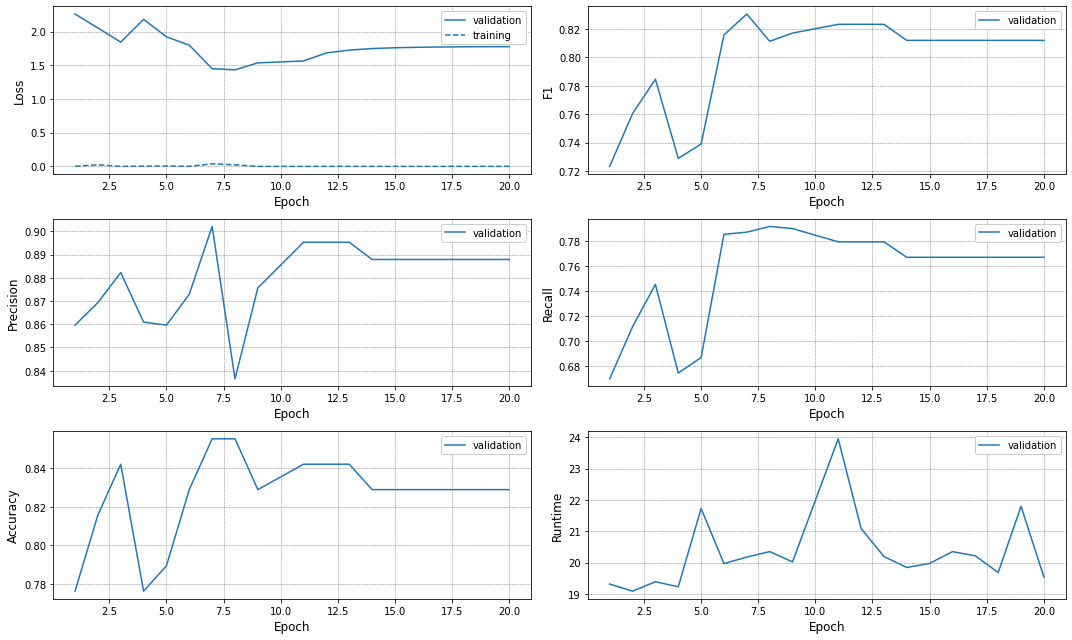

In [34]:
plt.figure(figsize=(15,9))
#plt.tight_layout()

metrics = ['eval_loss','eval_f1','eval_precision','eval_recall','eval_accuracy','eval_runtime']

for idx, metric in enumerate(metrics):
    with plt.style.context(['grid']):
        plt.tight_layout()
        ax = plt.subplot(3,2,idx+1).plot(lrbt_history['epoch'],
                                    lrbt_history[metric],
                                    label='validation')

        #Also plot training loss when plotting validation loss
        if metric == 'eval_loss':
            ax = plt.subplot(3,2,idx+1).plot(lrbt_history['epoch'],
                                             lrbt_history['loss'],
                                             color = ax[0].get_color(),
                                             linestyle= "--",
                                             label='training')

        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel(metric.replace('eval_','').capitalize(),fontsize=12)
        plt.legend()

The metric I prioritize for model evaluation is F1 given it tries to balance precision and recall. I also consider precision and recall as well. Based on this, the best model/checkpoint from our training procedure was obtained around epoch 6, outperforming all other checkpoints. We determine the specific checkpoint below.

We also note that the validation loss is a lot higher than the training loss. This might indicate that the model is overfitting the data. We contrast both the training and validation performanc below and also plot a confusion matrix and classification report to get more context into the model's performance.

#### • Determine the best checkpoint
**Note:** All checkpoints except the best were deleted so the cell below will yield different results if rerun!

In [ ]:
from glob import glob
import re

#List to store validation set results for the different checkpoints
val_results = []

#Iterate through all the subfolders in the bertweet directory          
for folder in glob('../models/bertweet/loss-reweighted/*/'):
    
    #If it is a model save checkpoint
    if 'checkpoint' in folder:
    
        #Load the checkpoint
        val_model = AutoModelForSequenceClassification.from_pretrained(folder)

        lrbt_val_training_args = TrainingArguments(
           output_dir = "../model_predictions",
           do_predict = True)

        lrbt_val_trainer = Trainer(
            model           = val_model,
            args            = lrbt_val_training_args,
            compute_metrics = compute_metrics)

        model_preds_and_results = lrbt_val_trainer.predict(val_set_dataset)

        val_results.append(model_preds_and_results[-1])

In [44]:
lrbt_results_df = pd.DataFrame(val_results)
lrbt_results_df.insert(0,'model_checkpoint',[re.search('checkpoint-\d+',checkpoint)[0] for checkpoint in (glob('../models/bertweet/loss-reweighted/*/')) if 'checkpoint' in checkpoint])

In [45]:
lrbt_results_df

,model_checkpoint,test_loss,test_f1,test_precision,test_recall,test_accuracy,test_runtime,test_samples_per_second,test_steps_per_second
0,checkpoint-80,1.172140,0.833726,0.893827,0.796153,0.855263,19.9767,3.804,0.501
1,checkpoint-20,1.505375,0.771673,0.877778,0.723658,0.828947,19.7493,3.848,0.506
2,checkpoint-100,1.505769,0.823188,0.895297,0.779213,0.842105,19.8654,3.826,0.503
3,checkpoint-140,1.571644,0.811908,0.887879,0.766868,0.828947,19.5962,3.878,0.510
4,checkpoint-60,1.523013,0.804710,0.895730,0.757680,0.828947,19.5329,3.891,0.512
5,checkpoint-40,1.800098,0.739035,0.859585,0.686621,0.789474,19.3359,3.931,0.517
6,checkpoint-160,1.575190,0.811908,0.887879,0.766868,0.828947,19.7466,3.849,0.506
7,checkpoint-120,1.558509,0.811908,0.887879,0.766868,0.828947,19.3688,3.924,0.516


Checkpoint-80 appears to have performed the best across all metrics.

#### • Load the best checkpoint

In [35]:
#Load the model
lsrw_model = AutoModelForSequenceClassification.from_pretrained("../models/bertweet/loss-reweighted/checkpoint-80")

lsrw_training_args = TrainingArguments(
    output_dir = "../model_predictions",
    do_predict = True
)

lsrw_trainer = Trainer(
    model           = lsrw_model,
    args            = lsrw_training_args,
    compute_metrics = compute_metrics,
)


loading configuration file ../models/bertweet/loss-reweighted/checkpoint-80/config.json
Model config RobertaConfig {
  "_name_or_path": "finiteautomata/bertweet-base-sentiment-analysis",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "NEG",
    "1": "NEU",
    "2": "POS"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "NEG": 0,
    "NEU": 1,
    "POS": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.8.0",
  "type_vocab_size": 1,
  "use_cache

#### • Evaluating the model: How well does it classify tweets?

**Training set**

In [36]:
lsrw_train = lsrw_trainer.predict(train_set_dataset, metric_key_prefix= 'train')

***** Running Prediction *****
  Num examples = 225
  Batch size = 8


In [37]:
pd.DataFrame([lsrw_train[-1]])

,train_loss,train_f1,train_precision,train_recall,train_accuracy,train_runtime,train_samples_per_second,train_steps_per_second
0,0.000063,1.0,1.0,1.0,1.0,57.8358,3.89,0.501


Perfect training set prediction

**Validation set**

In [38]:
lsrw_validation = lsrw_trainer.predict(val_set_dataset, metric_key_prefix= 'val')

***** Running Prediction *****
  Num examples = 76
  Batch size = 8


In [39]:
pd.DataFrame([lsrw_validation[-1]])

,val_loss,val_f1,val_precision,val_recall,val_accuracy,val_runtime,val_samples_per_second,val_steps_per_second
0,1.17214,0.833726,0.893827,0.796153,0.855263,20.7294,3.666,0.482


**Validation set classification report**

In [44]:
lsrw_val_y_true = df.query("split_group == 'validation_set' ").label.tolist()
lsrw_val_preds = np.argmax(lsrw_validation[0], axis=1).flatten()

print(classification_report(lsrw_val_y_true, lsrw_val_preds))

              precision    recall  f1-score   support

           0       0.87      0.91      0.89        43
           1       0.81      0.81      0.81        27
           2       1.00      0.67      0.80         6

    accuracy                           0.86        76
   macro avg       0.89      0.80      0.83        76
weighted avg       0.86      0.86      0.85        76



In [45]:
lsrw_cm = confusion_matrix(lsrw_val_y_true, lsrw_val_preds)
lsrw_disp = ConfusionMatrixDisplay(confusion_matrix = lsrw_cm, display_labels = ['Negative', 'Neutral', 'Positive'])

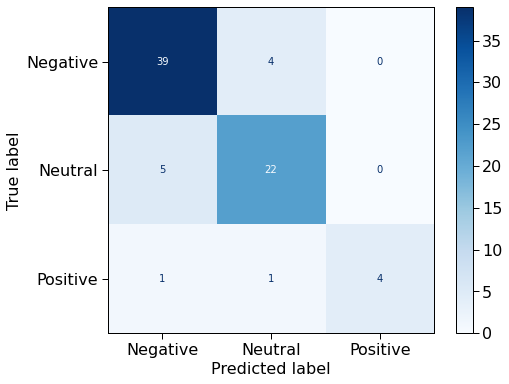

In [47]:
#Plot the confusion matrix
with plt.style.context(['notebook','no-latex']):
    lsrw_disp.plot(cmap='Blues',ax=None)
    plt.grid(False)
    plt.show()

#### • View misclassified tweets

In [48]:
lsrw_valid_df = df.query("split_group == 'validation_set' ")
lsrw_valid_df['model_preds'] = lsrw_val_preds 
lsrw_misclassified = lsrw_valid_df[lsrw_valid_df.label != lsrw_valid_df.model_preds][['Text','sentiment','model_preds']]
lsrw_misclassified.model_preds = lsrw_misclassified.model_preds.map({0:'Negative', 1: 'Neutral', 2: 'Positive'})

with pd.option_context('display.max_colwidth', None):
  display(lsrw_misclassified)

/Users/koredeakande/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Text,sentiment,model_preds
25,mtewww.....this was my predicament before i bought spectranet_ng jeje!,Positive,Negative
61,oluwadamilolaog femi_martinsog you are cheating on your darling spectranet again.,Neutral,Negative
78,spectranet expecting me to subscribe without sending double data offer. jokers i want double data plus rollover so till then we wait.,Neutral,Negative
113,"iyawothickabody one time spectranet called, i refused to pick because i didn't have money to subscribe so i just ignored it like 4 times. the fifth time, true caller showed union bank, i picked thinking i have passed interview o only to hear 'your spectranet...😂😂😂 they got me😂",Neutral,Negative
155,trying to enjoy my movie but tizeti out here like,Negative,Neutral
222,specy spectranet_ng warris all dis na! la ta aro!,Negative,Neutral
260,zimmani jerrierotimi spectranet_ng they're all the same,Neutral,Negative
261,na gprs una dey run me no lie spectranet_ng,Negative,Neutral
324,socrateserasmus mtnng gonna buy spectranet tomorrow! mtn has made me finish my house rent 😩😩😭,Positive,Neutral
348,is there any internet service provider in nigeria that offers unlimited data for a month with no cap ? asides tizeti please,Negative,Neutral


#### • Results discussion

Comparing the classification report and the confusion matrix above to those of the other BerTweet models, we see that this model improved on most fronts, most notably in terms of positive sample prediction. From the classification report, however, we note that it's overall recall worsens – seemingly due to the low recall on the positive class.

These results suggest that loss function reweighting and increasing the batch size for beneficial for the training process, especially in improving positive sample prediciton. However, I am a bit skeptical about this model compared to the one obtained from default training because the validation loss is significantly higher (almost double). This might suggest the model won't generalize well to new data despite performing better on the given validation set.


Next, I experiment with oversampling the positive class to see if it yields even better results

---

### 5(iii) Modified BerTweet (v2)
`Oversampling/resampling positive class`

#### • Oversample the positive sample to the size of the neutral class

In [17]:
#Make a copy of the training data for oversampling and drop all positive sample
#We DO NOT oversample the validation set as we want it to mirror the true class distribution
#and be similar to the the test data
training_df = df.query(" split_group == 'training_set' ")
oversampled_df = training_df.copy().query(" sentiment != 'Positive' ")

In [18]:
#Oversample the positive samples to the size of the neutral class
pos_samples = training_df.query("sentiment == 'Positive'").sample(training_df.\
                                                                  sentiment.value_counts()['Negative'], 
                                                                  replace=True)

In [19]:
#Merge the positive samples, shuffle, and reset index
oversampled_df = oversampled_df.append(pos_samples).sample(frac=1).reset_index(drop=True)

#### • Quick preview of the resampled data

In [20]:
oversampled_df

,ISP_Name,Time,Text,Source,sentiment,label,split_group
0,sprectranet,2019-07-11 12:33:10,mr_pepro nothing oh i miss spectranet noni. i'...,Twitter for Android,Positive,2,training_set
1,sprectranet,2019-06-21 05:58:06,thanks gidi_traffic for helping with the poll....,Twitter for Android,Positive,2,training_set
2,sprectranet,2019-05-29 15:59:11,"shamsiyya__ dead fc, jump unto spectranet",Twitter for iPhone,Positive,2,training_set
3,sprectranet,2020-09-03 17:56:32+00:00,i was not told spectranet network is now shitt...,Twitter for iPhone,Negative,0,training_set
4,sprectranet,2019-02-21 20:32:01,"i'd have to retire back to spectranet, 🙃. i'm ...",Twitter for iPhone,Negative,0,training_set
...,...,...,...,...,...,...,...
331,sprectranet,2020-01-04 16:20:15+00:00,aniruoje buy spectranet_ng,Twitter for Android,Positive,2,training_set
332,sprectranet,2019-03-26 17:27:56,hay god. spectranet won't kill me. what is goi...,Twitter for iPhone,Negative,0,training_set
333,tizeti,2019-12-14 08:30:59+00:00,chrisnwasike tizeti yes o,Twitter for Android,Neutral,1,training_set
334,sprectranet,2020-05-10 23:53:37+00:00,kenethelion identikaltwins smilecomsng spectra...,Twitter for iPhone,Negative,0,training_set


In [21]:
#Check the class proportions
oversampled_df.sentiment.value_counts(normalize=True)

Positive    0.383929
Negative    0.383929
Neutral     0.232143
Name: sentiment, dtype: float64

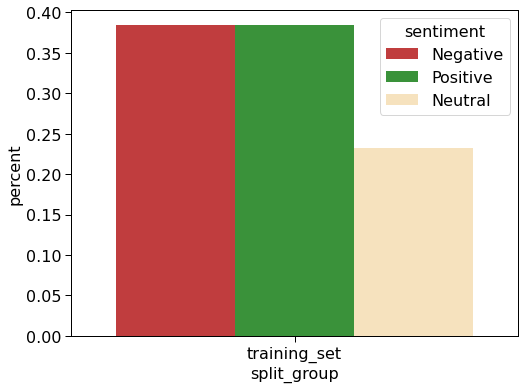

In [22]:
#Plot the proportion of each sentiment class in the training set
with plt.style.context(['notebook','no-latex']):
    sns.barplot(x='split_group', 
                y='percent', 
                hue='sentiment', 
                palette = ['tab:red','tab:green','moccasin'],
                data=oversampled_df.groupby(['split_group'])['sentiment'].value_counts(normalize=True).\
                rename('percent').\
                reset_index())
    plt.show()

### a. Encode the training and validation sets

In [23]:
#Prepare the Training and validation sets
oversampled_train_dataset = Generate_PyTorch_Dataset(
    texts     = oversampled_df.query("split_group == 'training_set' ").Text.tolist(),
    labels    = oversampled_df.query("split_group == 'training_set' ").label.tolist(),
    tokenizer = tokenizer
)

val_set_dataset = Generate_PyTorch_Dataset(
    texts    = df.query("split_group == 'validation_set' ").Text.tolist(),
    labels = df.query("split_group == 'validation_set' ").label.tolist(),
    tokenizer  = tokenizer
)

### b. Train/finetune the model

In [26]:
#Load the model
oversampled_model = AutoModelForSequenceClassification.from_pretrained("finiteautomata/bertweet-base-sentiment-analysis")

#Define the training parameters
oversampling_training_args = TrainingArguments(
    output_dir                  = "../models/bertweet/after-oversampling",
    num_train_epochs            = 10,
    seed                        = 91,
    save_strategy               = "epoch",
    logging_strategy            = "epoch",
    evaluation_strategy         = "epoch"

)

#Define Trainer object
oversampling_trainer = Trainer(
    model           = oversampled_model,
    args            = oversampling_training_args,
    train_dataset   = oversampled_train_dataset,
    eval_dataset    = val_set_dataset,
    compute_metrics = compute_metrics
)

oversampling_trainer.train()

loading configuration file https://huggingface.co/finiteautomata/bertweet-base-sentiment-analysis/resolve/main/config.json from cache at /Users/koredeakande/.cache/huggingface/transformers/cb09766f7ba60b5f7a1bb640617b24f1499c4a6f3ab160c4a0ac171e3a377c68.008dca06003188334001a96363da79ced4944abc68d94a2f1e0db786dc5aa08b
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "NEG",
    "1": "NEU",
    "2": "POS"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "NEG": 0,
    "NEU": 1,
    "POS": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,


Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
1,0.572900,0.964274,0.622474,0.883838,0.586420,0.697368
2,0.211300,0.745115,0.800355,0.880486,0.754522,0.815789
3,0.084600,0.768868,0.766126,0.867955,0.720500,0.815789
4,0.072500,1.124787,0.738171,0.878114,0.682027,0.789474
5,0.058400,1.054764,0.744974,0.884175,0.689779,0.802632
6,0.017100,1.029478,0.750808,0.867499,0.698966,0.802632
7,0.002300,1.082675,0.750808,0.867499,0.698966,0.802632
8,0.001900,1.131862,0.750808,0.867499,0.698966,0.802632
9,0.002200,1.165490,0.750808,0.867499,0.698966,0.802632
10,0.001600,1.175239,0.750808,0.867499,0.698966,0.802632


***** Running Evaluation *****
  Num examples = 76
  Batch size = 8
Saving model checkpoint to ../models/bertweet/after-oversampling/checkpoint-42
Configuration saved in ../models/bertweet/after-oversampling/checkpoint-42/config.json
Model weights saved in ../models/bertweet/after-oversampling/checkpoint-42/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 76
  Batch size = 8
Saving model checkpoint to ../models/bertweet/after-oversampling/checkpoint-84
Configuration saved in ../models/bertweet/after-oversampling/checkpoint-84/config.json
Model weights saved in ../models/bertweet/after-oversampling/checkpoint-84/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 76
  Batch size = 8
Saving model checkpoint to ../models/bertweet/after-oversampling/checkpoint-126
Configuration saved in ../models/bertweet/after-oversampling/checkpoint-126/config.json
Model weights saved in ../models/bertweet/after-oversampling/checkpoint-126/pytorch_model.bin
***** Running Ev

TrainOutput(global_step=420, training_loss=0.10247192781950747, metrics={'train_runtime': 3129.5651, 'train_samples_per_second': 1.074, 'train_steps_per_second': 0.134, 'total_flos': 348112622592000.0, 'train_loss': 0.10247192781950747, 'epoch': 10.0})

In [31]:
#Get the training logs
oversampled_history = pd.DataFrame(oversampling_trainer.state.log_history)
oversampled_history.to_csv("../models/logs/oversampled_logs.csv",index=False)
oversampled_history = oversampled_history.fillna(method='bfill', limit=1).drop_duplicates(subset=['epoch','eval_loss'])

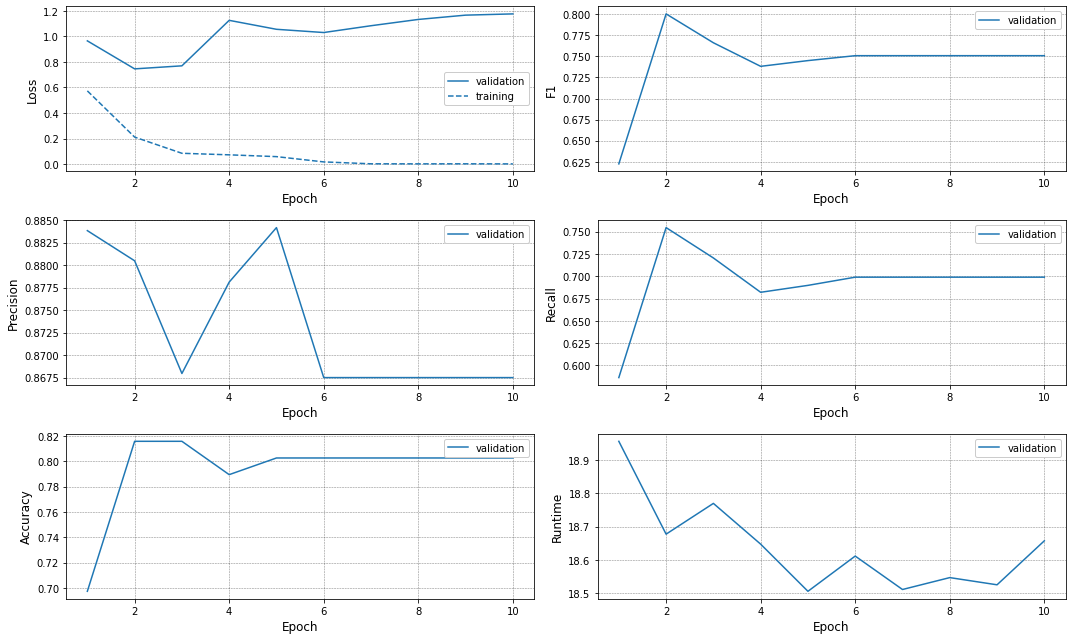

In [32]:
plt.figure(figsize=(15,9))

metrics = ['eval_loss','eval_f1','eval_precision','eval_recall','eval_accuracy','eval_runtime']

for idx, metric in enumerate(metrics):
    with plt.style.context(['grid']):
        plt.tight_layout()
        
        ax = plt.subplot(3,2,idx+1).plot(oversampled_history['epoch'],
                                         oversampled_history[metric],
                                         label='validation')

        #Also plot training loss when plotting validation loss
        if metric == 'eval_loss':
            ax = plt.subplot(3,2,idx+1).plot(oversampled_history['epoch'],
                                             oversampled_history['loss'],
                                             color = ax[0].get_color(),
                                             linestyle= "--",
                                             label='training')

        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel(metric.replace('eval_','').capitalize(),fontsize=12)
        plt.legend()

- Epoch 2 (**checkpoint-84**) is the best across all metrics
- However, not better than the models we trained above. 
- Performance seemed to worsen and then remain constant overtime

**I don't bother digging deeper into results since it performed worse on the validation set (compared to models finetuned above) based on the results directly above.**

---

# Tackling overfitting
Despite achieving pretty good results on the validation set, we note that all the models finetuned above appear to overfit on the training data. This is evidenced by the much higher validation loss than train loss, and the much higher performance (perfect prediction!) on the train set than the test set.

Below I explore methods to potentially reduce this overfitting occurrence and, in turn, increase generalization ability.

Specifically I test the following methods:
- Adding a weight decay to penalize complexity and keep the weights as small as possible

## Adding a weight decay to 

In [17]:
# Define the training parameters
training_args = TrainingArguments(
    output_dir                  = "../models",
    num_train_epochs            = 10,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size  = 64,
    warmup_steps                = 500,
    weight_decay                = 0.01,
    save_strategy               = "epoch",
    evaluation_strategy         = "epoch"
)

#Define Trainer object
trainer = Trainer(
    model           = model,
    args            = training_args,
    train_dataset   = train_set_dataset,
    eval_dataset    = val_set_dataset,
    compute_metrics = compute_metrics
)

trainer.train('../models/checkpoint-75')

Loading model from ../models/checkpoint-75).
***** Running training *****
  Num examples = 226
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 150
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 5
  Continuing training from global step 75
  Will skip the first 5 epochs then the first 0 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss,F1,Precision,Recall,Accuracy
6,No log,0.763013,0.570215,0.630990,0.644737,0.644737
7,No log,0.702986,0.708169,0.716233,0.750000,0.750000
8,No log,0.685107,0.731384,0.702577,0.763158,0.763158
9,No log,0.666470,0.756062,0.728259,0.789474,0.789474
10,No log,0.732520,0.742764,0.716873,0.776316,0.776316


***** Running Evaluation *****
  Num examples = 76
  Batch size = 64
/Users/koredeakande/opt/anaconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to ../models/checkpoint-90
Configuration saved in ../models/checkpoint-90/config.json
Model weights saved in ../models/checkpoint-90/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 76
  Batch size = 64
/Users/koredeakande/opt/anaconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, 

TrainOutput(global_step=150, training_loss=0.2528162129720052, metrics={'train_runtime': 6676.7605, 'train_samples_per_second': 0.338, 'train_steps_per_second': 0.022, 'total_flos': 594636324065280.0, 'train_loss': 0.2528162129720052, 'epoch': 10.0})

From the above results, the checkpoint from epoch 9 (checkpoint-135) does the best across all metrics. I also had a similar checkpoint in a previous run (see Appendix). We thus compare both checkpoints on metrics to prioritize one:

In [28]:
checkpoint_135 = {'Validation Loss': 0.666470, 'F1': 0.756062, 'Precision': 0.728259, 
                  'Recall': 0.789474, 'Accuracy': 0.789474}

checkpoint_174 = {'Validation Loss': 0.905348, 'F1': 0.756738, 'Precision': 0.727052, 
                  'Recall': 0.789474, 'Accuracy': 0.789474}


pd.DataFrame([checkpoint_135,checkpoint_174], index= ['checkpoint_135','checkpoint_174'])

,Validation Loss,F1,Precision,Recall,Accuracy
checkpoint_135,0.666470,0.756062,0.728259,0.789474,0.789474
checkpoint_174,0.905348,0.756738,0.727052,0.789474,0.789474


We see a tradeoff between F1 and precision (not surprising given that F1 tries to balance precision and recall). In this scenario, I don't have a reason to believe precision is more important than recall (i.e. it is important to consider false positives and false negatives for the classes). Hence I decide to go with checkpoint_174 for future predictions. I also keep checkpoint_135, just in case, but I delete all other checkpoints (including those listed in the Appendix)

**Note:** Here, I don't really pay attention to accuracy (although in this scenario they are the same) because we have a really uneven class distribution, and the accuracy would be misleading.

### 6. Test set Prediction with the Fine-tuned BERT

In [29]:
# Load the checkpoint
model = BertForSequenceClassification.from_pretrained("../models/checkpoint-174")

# Make the test set ready
test_set_dataset = Generate_PyTorch_Dataset(
    texts    = df.query("split_group == 'test_set' ").Text.tolist(),
    labels = df.query("split_group == 'test_set' ").label.tolist(),
    tokenizer  = tokenizer
)

training_args = TrainingArguments(
    output_dir = "../model_predictions",
    do_predict = True
)

trainer = Trainer(
    model           = model,
    args            = training_args,
    compute_metrics =compute_metrics,
)

test_preds = trainer.predict(test_set_dataset)

loading configuration file ../models/checkpoint-174/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-multilingual-cased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification

/Users/koredeakande/opt/anaconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
pd.DataFrame([test_preds[-1]])

,test_loss,test_f1,test_precision,test_recall,test_accuracy,test_runtime,test_samples_per_second,test_steps_per_second
0,1.057386,0.704644,0.677688,0.736842,0.736842,83.9709,0.905,0.119


### 7. Evaluating the model: How well does it classify tweets?

In [31]:
y_true = df.query("split_group == 'test_set' ").label.tolist()
preds = np.argmax(test_preds[0], axis=1).flatten()

print(classification_report(y_true, preds))

              precision    recall  f1-score   support

           0       0.72      0.69      0.71        26
           1       0.75      0.86      0.80        44
           2       0.00      0.00      0.00         6

    accuracy                           0.74        76
   macro avg       0.49      0.52      0.50        76
weighted avg       0.68      0.74      0.70        76



/Users/koredeakande/opt/anaconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/koredeakande/opt/anaconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/koredeakande/opt/anaconda3/envs/jupyterlab/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

In [32]:
cm = confusion_matrix(y_true, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['Negative', 'Neutral', 'Positive'])

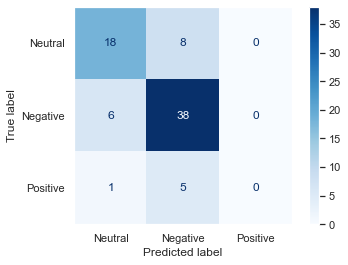

In [33]:
disp.plot(cmap='Blues',ax=None)
plt.grid(False)
plt.show()

### 8. Conclusions

- It does fairly well differentiating between neutral and negative tweets.
- However, it model does poorly predicting positive tweets. This is not surprising given it has very few positive tweets to train with to start with. 

Hence it would be helpful to consider strategies to handle the imbalance and improve prediction of positive samples. Some potential strategies include:
- Reweighting the classes in the loss function to penalize more for positive samples misclassification
- Oversampling (or sampling with replacement) so that positive cases are more represented in the dataset
- Try other algorithms that are known to do well with imbalanced datasets (e.g. decision trees, random forests, etc.)

Sources consulted for inspiration:
- [8 Tactics to Combat Imbalanced Classes in Your Machine Learning Dataset by Jason Brownlee](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/)

---